# SMBC Group GREEN×DATA Challenge 2025 for Recruiting

https://signate.jp/competitions/1634

* 評価指標: RMSE

In [74]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
import lightgbm as lgb

from config import COMPETITION_ID


warnings.filterwarnings("ignore")

# Read Data

In [100]:
class Paths:
    p = "../data/"

    train = p + "train.csv"
    test = p + "test.csv"
    sample_submission = p + "sample_submit.csv"

In [76]:
train = pd.read_csv(Paths.train)
test = pd.read_csv(Paths.test)

In [77]:
train.head()

,time,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,...,seville_wind_deg,seville_rain_1h,seville_rain_3h,seville_snow_3h,seville_clouds_all,seville_weather_id,seville_weather_main,seville_weather_description,seville_weather_icon,price_actual
0,2015-01-02 00:00:00+01:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,33,0.0,0.0,0.0,0,800,clear,sky is clear,01n,64.02
1,2015-01-02 01:00:00+01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,33,0.0,0.0,0.0,0,800,clear,sky is clear,01n,58.46
2,2015-01-02 02:00:00+01:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,44,0.0,0.0,0.0,0,800,clear,sky is clear,01n,54.70
3,2015-01-02 03:00:00+01:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,44,0.0,0.0,0.0,0,800,clear,sky is clear,01n,54.91
4,2015-01-02 04:00:00+01:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,44,0.0,0.0,0.0,0,800,clear,sky is clear,01n,53.07


In [78]:
train.shape

(26280, 92)

In [79]:
train.isnull().sum()[train.isnull().sum() > 0]

generation_biomass                             21
generation_fossil_brown_coal/lignite           20
generation_fossil_gas                          20
generation_fossil_hard_coal                    20
generation_fossil_oil                          21
generation_hydro_pumped_storage_consumption    21
generation_hydro_run_of_river_and_poundage     21
generation_hydro_water_reservoir               20
generation_nuclear                             19
generation_other                               20
generation_other_renewable                     20
generation_solar                               20
generation_waste                               21
generation_wind_onshore                        20
total_load_actual                              37
dtype: int64

<Axes: >

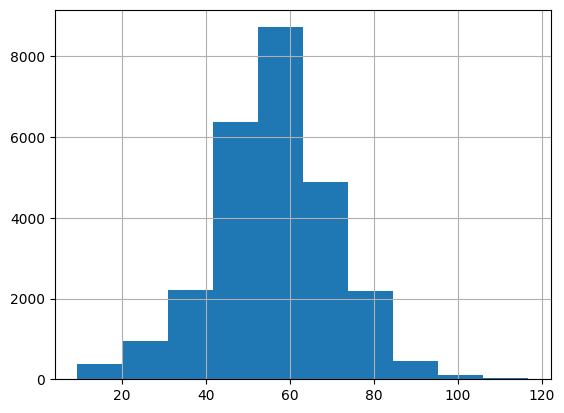

In [80]:
train["price_actual"].hist()

# Feature Engineering

In [81]:
features = [
    "time",
    "total_load_actual",
    "generation_fossil_gas",
    "generation_fossil_hard_coal",
    "generation_fossil_oil",
    "generation_solar",
    "generation_wind_onshore",
    "generation_hydro_run_of_river_and_poundage",
    "valencia_temp",
]

X_train = train[features]
y_train = train["price_actual"]



print(X_train.shape)
print(y_train.shape)

(26280, 9)
(26280,)


# Training

In [82]:
X_train['time'] = pd.to_datetime(X_train['time'], utc=True)

In [83]:
print(X_train.time.min())
print(X_train.time.max())

2015-01-01 23:00:00+00:00
2017-12-31 22:00:00+00:00


In [84]:
X_train.dtypes

time                                          datetime64[ns, UTC]
total_load_actual                                         float64
generation_fossil_gas                                     float64
generation_fossil_hard_coal                               float64
generation_fossil_oil                                     float64
generation_solar                                          float64
generation_wind_onshore                                   float64
generation_hydro_run_of_river_and_poundage                float64
valencia_temp                                             float64
dtype: object

In [85]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    'random_state': 123,
}

In [86]:
X_train.dtypes

time                                          datetime64[ns, UTC]
total_load_actual                                         float64
generation_fossil_gas                                     float64
generation_fossil_hard_coal                               float64
generation_fossil_oil                                     float64
generation_solar                                          float64
generation_wind_onshore                                   float64
generation_hydro_run_of_river_and_poundage                float64
valencia_temp                                             float64
dtype: object

In [87]:
validate_start = pd.Timestamp('2017-01-01', tz='UTC')

x_tr = X_train[X_train["time"] < validate_start]
y_tr = y_train[X_train["time"] < validate_start]

x_va = X_train[X_train["time"] >= validate_start]
y_va = y_train[X_train["time"] >= validate_start]

In [88]:
x_tr = x_tr.drop(columns=["time"])
x_va = x_va.drop(columns=["time"])

In [89]:
x_tr.shape, y_tr.shape, x_va.shape, y_va.shape

((17521, 8), (17521,), (8759, 8), (8759,))

In [90]:
model = lgb.LGBMRegressor(**params)

model.fit(
    x_tr,
    y_tr,
    eval_set=[(x_tr, y_tr), (x_va, y_va)],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100, verbose=True),
        lgb.log_evaluation(0)
    ],
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2026
[LightGBM] [Info] Number of data points in the train set: 17521, number of used features: 8
[LightGBM] [Info] Start training from score 54.379606
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	training's rmse: 9.54115	valid_1's rmse: 10.939


LGBMRegressor(metric='rmse', n_estimators=100000, num_leaves=16,
              objective='regression', random_state=123)

In [91]:
y_tr_pred = model.predict(x_tr)
y_va_pred = model.predict(x_va)

rmse_tr = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
rmse_va = np.sqrt(mean_squared_error(y_va, y_va_pred))

In [92]:
imp = pd.DataFrame({
    'col': x_tr.columns,
    'imp': model.feature_importances_,
})
imp

,col,imp
0,total_load_actual,142
1,generation_fossil_gas,138
2,generation_fossil_hard_coal,189
3,generation_fossil_oil,204
4,generation_solar,144
5,generation_wind_onshore,123
6,generation_hydro_run_of_river_and_poundage,240
7,valencia_temp,200


In [93]:
print(rmse_tr, rmse_va)

9.541151901353528 10.938956099045052


# Submit

In [94]:
test = pd.read_csv(Paths.test)
test.shape

(8760, 91)

In [95]:
X_test = test[features]
X_test.shape

(8760, 9)

In [96]:
X_test = X_test.drop(columns=["time"])

In [101]:
submit = pd.read_csv(Paths.sample_submission)
submit.head(10)

,2018-01-01 00:00:00+01:00,0
0,2018-01-01 01:00:00+01:00,0
1,2018-01-01 02:00:00+01:00,0
2,2018-01-01 03:00:00+01:00,0
3,2018-01-01 04:00:00+01:00,0
4,2018-01-01 05:00:00+01:00,0
5,2018-01-01 06:00:00+01:00,0
6,2018-01-01 07:00:00+01:00,0
7,2018-01-01 08:00:00+01:00,0
8,2018-01-01 09:00:00+01:00,0
9,2018-01-01 10:00:00+01:00,0


In [107]:
y_test_pred = model.predict(X_test)

df_submit = pd.DataFrame({
    'time': test["time"],
    'price': y_test_pred
})
df_submit

,time,price
0,2018-01-01 00:00:00+01:00,44.123536
1,2018-01-01 01:00:00+01:00,46.739740
2,2018-01-01 02:00:00+01:00,39.679164
3,2018-01-01 03:00:00+01:00,41.245468
4,2018-01-01 04:00:00+01:00,40.762179
...,...,...
8755,2018-12-31 19:00:00+01:00,52.161905
8756,2018-12-31 20:00:00+01:00,57.348741
8757,2018-12-31 21:00:00+01:00,56.993322
8758,2018-12-31 22:00:00+01:00,55.690018


In [110]:
output_dir = "../output/"
output_file_path = output_dir + "first_submit.csv"

In [111]:
df_submit.to_csv(output_file_path, index=False, header=None)

In [112]:
!signate submit --competition-id={COMPETITION_ID} {output_file_path}

You have successfully submitted your predictions.We will send you the submission result to your email address.
